In [1]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1: Train Acc=0.7525, Val Acc=0.7570
Epoch 2: Train Acc=0.7976, Val Acc=0.7570
Epoch 3: Train Acc=0.7976, Val Acc=0.7570
Epoch 4: Train Acc=0.7976, Val Acc=0.7570
Epoch 5: Train Acc=0.7976, Val Acc=0.7570
Epoch 6: Train Acc=0.7976, Val Acc=0.7570
Epoch 7: Train Acc=0.8052, Val Acc=0.7848
Epoch 8: Train Acc=0.8242, Val Acc=0.7823
Epoch 9: Train Acc=0.8211, Val Acc=0.7924
Epoch 10: Train Acc=0.8287, Val Acc=0.7975
Epoch 11: Train Acc=0.8376, Val Acc=0.8000
Epoch 12: Train Acc=0.8452, Val Acc=0.8127
Epoch 13: Train Acc=0.8458, Val Acc=0.8076
Epoch 14: Train Acc=0.8585, Val Acc=0.8177
Epoch 15: Train Acc=0.8591, Val Acc=0.8203
Epoch 16: Train Acc=0.8617, Val Acc=0.8177
Epoch 17: Train Acc=0.8642, Val Acc=0.8278
Epoch 18: Train Acc=0.8610, Val Acc=0.8304
Epoch 19: Train Acc=0.8712, Val Acc=0.8354
Epoch 20: Train Acc=0.8737, Val Acc=0.8380
Epoch 21: Train Acc=0.8750, Val Acc=0.8278
Epoch 22: Train Acc=0.8769, Val Acc=0.8329
Epoch 23: Train Acc=0.8801, Val Acc=0.8380
Epoch 24: Train Acc=

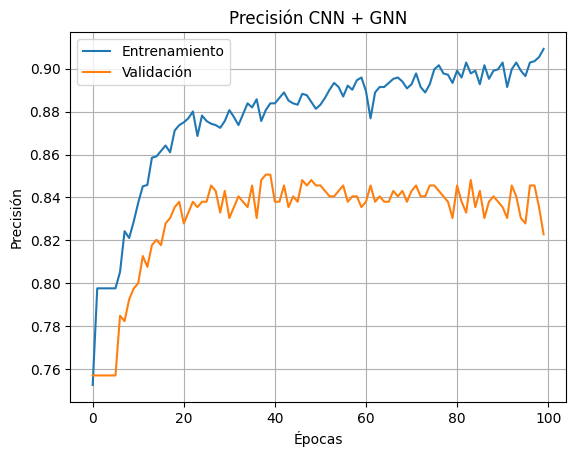

Predicción para 'AELRCMCIKTTSGIHPKNIQSLEVIGKGTHCNQVEVIATLKDGRKICLDPDAPRIKKIVQKKLAGD': 0.9134


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_max_pool

# Cargar datos
data = pd.read_csv("nueva_base_+300_final.csv")
data['Activity'] = data['Activity'].map({'Antibacterial': 1, 'Otros': 0})
data = data[data['Seqence'].apply(len) >= 3]  # Filtro

# Crear diccionario de aminoácidos
all_amino_acids = set("".join(data['Seqence']))
amino_acids_dict = {aa: i for i, aa in enumerate(sorted(all_amino_acids))}
max_length = max(data['Seqence'].apply(len))

# Codificación one-hot
def one_hot_encode_sequence(sequence, max_length, char_dict):
    encoded = np.zeros((max_length, len(char_dict)), dtype=np.float32)
    for i, char in enumerate(sequence[:max_length]):
        if char in char_dict:
            encoded[i, char_dict[char]] = 1.0
    return encoded

# Módulo CNN que reduce dimensionalidad antes de GNN
class CNNEncoder(nn.Module):
    def __init__(self, in_channels):
        super(CNNEncoder, self).__init__()
        self.conv = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float).permute(1, 0).unsqueeze(0)  # [1, features, length]
        x = self.pool(F.relu(self.conv(x)))  # [1, 32, reduced_len]
        return x.squeeze(0).permute(1, 0)  # [reduced_len, 32]

# Inicializar encoder
cnn_encoder = CNNEncoder(in_channels=len(amino_acids_dict))

# Convertir una secuencia a grafo después de CNN
def sequence_to_graph(sequence, label):
    one_hot = one_hot_encode_sequence(sequence, max_length, amino_acids_dict)
    with torch.no_grad():
        cnn_features = cnn_encoder(one_hot)  # ← CNN sobre la matriz one-hot
    num_nodes = cnn_features.shape[0]

    # Crear aristas entre nodos consecutivos
    edge_index = []
    for i in range(num_nodes - 1):
        edge_index.append([i, i + 1])
        edge_index.append([i + 1, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=cnn_features, edge_index=edge_index, y=torch.tensor([label], dtype=torch.float), num_nodes=num_nodes)

# Convertir base de datos
graph_data = [sequence_to_graph(seq, label) for seq, label in zip(data['Seqence'], data['Activity'])]

# Dividir datos
train_data, test_data = train_test_split(graph_data, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

# Modelo GNN (ya recibe vectores por nodo reducidos por CNN)
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, out_channels)
        self.lin = nn.Linear(out_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        x = global_max_pool(x, batch)
        return torch.sigmoid(self.lin(x)).view(-1)

# Entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel(in_channels=32, hidden_channels=64, out_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_acc_list, val_acc_list = [], []

for epoch in range(100):
    model.train()
    correct, total = 0, 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        preds = (output > 0.5).float()
        correct += (preds == batch.y).sum().item()
        total += batch.num_graphs
    train_acc = correct / total
    train_acc_list.append(train_acc)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            preds = (output > 0.5).float()
            correct += (preds == batch.y).sum().item()
            total += batch.num_graphs
    val_acc = correct / total
    val_acc_list.append(val_acc)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# Gráficas
plt.plot(train_acc_list, label='Entrenamiento')
plt.plot(val_acc_list, label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Precisión CNN + GNN")
plt.legend()
plt.grid()
plt.show()

# Guardar modelo
torch.save(model.state_dict(), "modelo_hibrido_cnn_gnn.pt")

# Predicción
def predecir_nueva_secuencia(secuencia):
    if len(secuencia) < 3:
        raise ValueError("Secuencia muy corta para procesar.")
    grafo = sequence_to_graph(secuencia, 0).to(device)
    model.eval()
    with torch.no_grad():
        pred = model(grafo)
    return pred.item()

# Ejemplo
secuencia_ejemplo = data['Seqence'].iloc[0]
pred = predecir_nueva_secuencia(secuencia_ejemplo)
print(f"Predicción para '{secuencia_ejemplo}': {pred:.4f}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1: Train Acc=0.7849, Val Acc=0.7570, Train Loss=0.5466, Val Loss=0.5460
Epoch 2: Train Acc=0.7976, Val Acc=0.7570, Train Loss=0.4934, Val Loss=0.5456
Epoch 3: Train Acc=0.7976, Val Acc=0.7570, Train Loss=0.4821, Val Loss=0.5232
Epoch 4: Train Acc=0.7976, Val Acc=0.7570, Train Loss=0.4655, Val Loss=0.4996
Epoch 5: Train Acc=0.7989, Val Acc=0.7772, Train Loss=0.4399, Val Loss=0.4675
Epoch 6: Train Acc=0.8211, Val Acc=0.8000, Train Loss=0.4112, Val Loss=0.4392
Epoch 7: Train Acc=0.8344, Val Acc=0.7899, Train Loss=0.3934, Val Loss=0.4360
Epoch 8: Train Acc=0.8484, Val Acc=0.8608, Train Loss=0.3781, Val Loss=0.4189
Epoch 9: Train Acc=0.8547, Val Acc=0.8203, Train Loss=0.3696, Val Loss=0.4171
Epoch 10: Train Acc=0.8566, Val Acc=0.8405, Train Loss=0.3616, Val Loss=0.4016
Epoch 11: Train Acc=0.8655, Val Acc=0.8633, Train Loss=0.3565, Val Loss=0.3968
Epoch 12: Train Acc=0.8693, Val Acc=0.8329, Train Loss=0.3480, Val Loss=0.4056
Epoch 13: Train Acc=0.8604, Val Acc=0.8658, Train Loss=0.3487

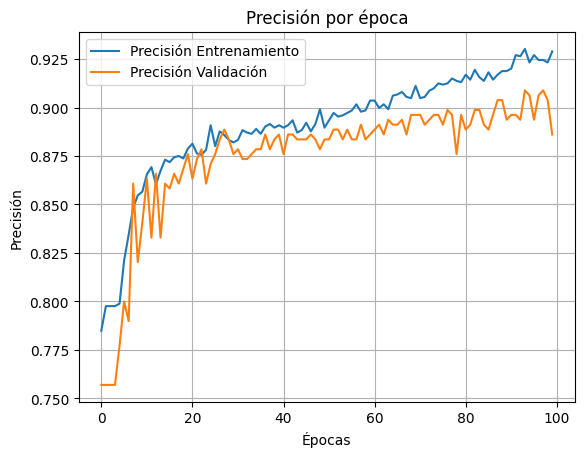

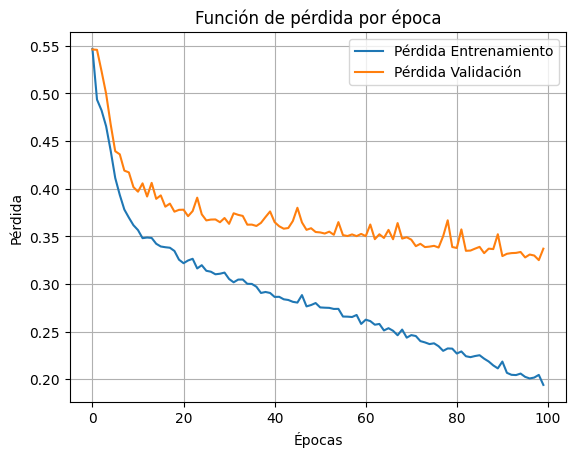

Predicción para 'AELRCMCIKTTSGIHPKNIQSLEVIGKGTHCNQVEVIATLKDGRKICLDPDAPRIKKIVQKKLAGD': 0.8389


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_max_pool

# Cargar datos
data = pd.read_csv("nueva_base_+300_final.csv")
data['Activity'] = data['Activity'].map({'Antibacterial': 1, 'Otros': 0})
data = data[data['Seqence'].apply(len) >= 3]  # Filtro

# Crear diccionario de aminoácidos
all_amino_acids = set("".join(data['Seqence']))
amino_acids_dict = {aa: i for i, aa in enumerate(sorted(all_amino_acids))}
max_length = max(data['Seqence'].apply(len))

# Codificación one-hot
def one_hot_encode_sequence(sequence, max_length, char_dict):
    encoded = np.zeros((max_length, len(char_dict)), dtype=np.float32)
    for i, char in enumerate(sequence[:max_length]):
        if char in char_dict:
            encoded[i, char_dict[char]] = 1.0
    return encoded

# Módulo CNN para extraer vectores de características por residuo
class CNNEncoder(nn.Module):
    def __init__(self, in_channels):
        super(CNNEncoder, self).__init__()
        self.conv = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float).permute(1, 0).unsqueeze(0)
        x = self.pool(F.relu(self.conv(x)))
        return x.squeeze(0).permute(1, 0)

cnn_encoder = CNNEncoder(in_channels=len(amino_acids_dict))

# Convertir secuencia en grafo con nodos embebidos por CNN
def sequence_to_graph(sequence, label):
    one_hot = one_hot_encode_sequence(sequence, max_length, amino_acids_dict)
    with torch.no_grad():
        cnn_features = cnn_encoder(one_hot)
    num_nodes = cnn_features.shape[0]

    edge_index = []
    for i in range(num_nodes - 1):
        edge_index.append([i, i + 1])
        edge_index.append([i + 1, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=cnn_features, edge_index=edge_index, y=torch.tensor([label], dtype=torch.float), num_nodes=num_nodes)

# Preparar dataset
graph_data = [sequence_to_graph(seq, label) for seq, label in zip(data['Seqence'], data['Activity'])]
train_data, test_data = train_test_split(graph_data, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

# Modelo GNN
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, out_channels)
        self.lin = nn.Linear(out_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        x = global_max_pool(x, batch)
        return torch.sigmoid(self.lin(x)).view(-1)

# Entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel(in_channels=32, hidden_channels=64, out_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []

for epoch in range(100):
    model.train()
    total_loss = 0
    correct, total = 0, 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (output > 0.5).float()
        correct += (preds == batch.y).sum().item()
        total += batch.num_graphs
    train_acc = correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(total_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch.y)
            total_val_loss += loss.item()
            preds = (output > 0.5).float()
            correct += (preds == batch.y).sum().item()
            total += batch.num_graphs
    val_acc = correct / total
    val_acc_list.append(val_acc)
    val_loss_list.append(total_val_loss / len(test_loader))

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss_list[-1]:.4f}, Val Loss={val_loss_list[-1]:.4f}")

# Gráficas
plt.plot(train_acc_list, label='Precisión Entrenamiento')
plt.plot(val_acc_list, label='Precisión Validación')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Precisión por época")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_list, label='Pérdida Entrenamiento')
plt.plot(val_loss_list, label='Pérdida Validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Función de pérdida por época")
plt.legend()
plt.grid()
plt.show()

# Guardar modelo
torch.save(model.state_dict(), "modelo_hibrido_cnn_gnn.pt")

# Predicción
def predecir_nueva_secuencia(secuencia):
    if len(secuencia) < 3:
        raise ValueError("Secuencia muy corta para procesar.")
    grafo = sequence_to_graph(secuencia, 0).to(device)
    model.eval()
    with torch.no_grad():
        pred = model(grafo)
    return pred.item()

# Ejemplo
secuencia_ejemplo = data['Seqence'].iloc[0]
pred = predecir_nueva_secuencia(secuencia_ejemplo)
print(f"Predicción para '{secuencia_ejemplo}': {pred:.4f}")